In [1]:
# ALWAYS RUN THIS CELL
# widen jupyter notebook window
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

from face_rhythm.util import helpers, setup
from pathlib import Path

# General Parameters
overwrite_config = False
remote           = False # Select true if running on any system where your kernel isn't on your local machine
trials           = False # Let us know if you're using trials and want to use them as a dimension in the factorization
multisession     = False # Set to true if you're doing a multisession analysis

# Project path, video path, and (optionally) run name
project_path     = Path(r'/media/rich/bigSSD RH/downloads_tmp/test_MC').resolve() # often Path.cwd().resolve() is useful
video_path       = Path(r'/media/rich/bigSSD RH/downloads_tmp').resolve() 
run_name         = 'motion_correction'

config_filepath = setup.setup_project(project_path, video_path, run_name, overwrite_config, remote, trials, multisession)

OpenCV version: 4.5.1
Pytorch version: 1.7.0


In [2]:
%load_ext autoreload
%autoreload 2
from face_rhythm.util import helpers, setup
# IMPORT VIDEOS
# See the docs for more information on video path setting
# https://face-rhythm.readthedocs.io/

config = helpers.load_config(config_filepath)
config['Video']['file_prefix'] = 'IMG_3273' # change this to 'session_prefix' if multisession
config['Video']['print_filenames'] = True
config['General']['overwrite_nwbs'] = False
helpers.save_config(config, config_filepath)

setup.prepare_videos(config_filepath)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'name': 'session', 'videos': ['/media/rich/bigSSD RH/downloads_tmp/IMG_3273.MOV']}
Current Session: session
number of videos: 1
number of frames per video (roughly): 10245
number of frames in ALL videos (roughly): 10245

 ['/media/rich/bigSSD RH/downloads_tmp/IMG_3273.MOV']
Sampling rate pulled from video file metadata:   29.972 frames per second


***
<center><h1>Motion Correction</h1></center>

***

<!-- ### Motion Correction

This is good if your animal doesn't fill the view and if you have stationary objects nearby. -->

<IPython.core.display.Javascript object>


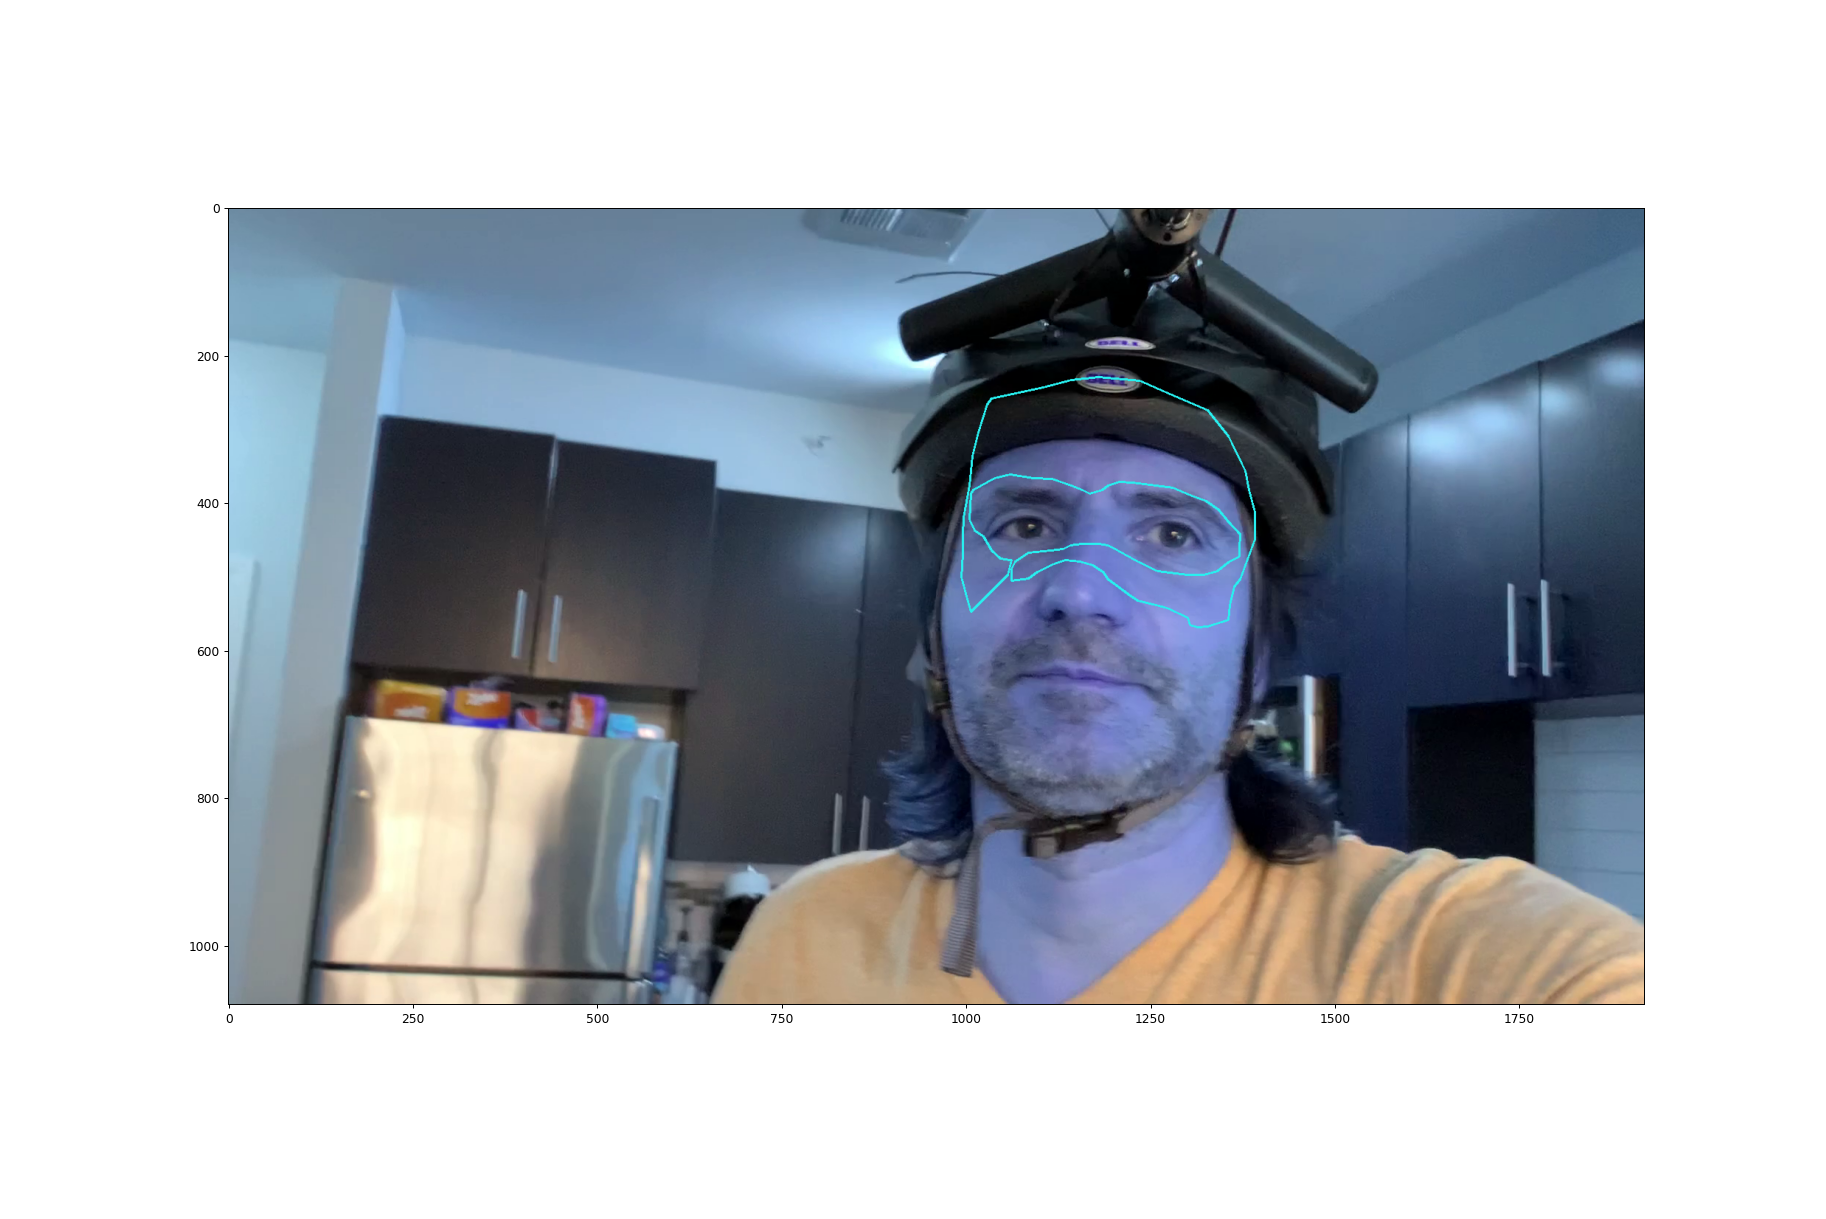

Button(description='Confirm ROI', style=ButtonStyle())

In [384]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

from face_rhythm.util import helpers, set_roi
import skimage.draw
import numpy as np

# Select Bounding ROI for this analysis
# This block of code will pop up a little GUI. Click around the
# region of the face that you want to include in the analysis.
# When you are done, click the 'Confirm ROI' button

config = helpers.load_config(config_filepath)
config['ROI']['session_to_set'] = 0 # 0 indexed. Chooses the session to use
config['ROI']['vid_to_set'] = 0 # 0 indexed. Sets the video to use to make an image
config['ROI']['frame_to_set'] = 1 # 0 indexed. Sets the frame number to use to make an image
config['ROI']['load_from_file'] = False # if you've already run this and want to use the existing ROI, set to True
helpers.save_config(config, config_filepath)

frame, bbox_selector = set_roi.get_roi(config_filepath)

In [385]:
import matplotlib.pyplot as plt
def crop_frame(im , pts_y , pts_x , plot_pref=0):
    im_crop = np.zeros_like(im)
    im_crop[pts_y,pts_x,...] = 1
    im_crop = im * im_crop
    if plot_pref:
        plt.figure()
        plt.imshow(im)
        plt.figure()
        plt.imshow(im_crop)
    
    return im_crop

pts = bbox_selector.selected_points
pts_y, pts_x = skimage.draw.polygon(np.array(pts)[:, 1], np.array(pts)[:, 0])

In [386]:
# Don't run this until you're done selecting
if not config['ROI']['load_from_file']:
    set_roi.process_roi(config_filepath, frame, bbox_selector)

Saving bbox_subframe_displacement in Group Original Points
Saving pts_displacement in Group Original Points
Saving pts_x_displacement in Group Original Points
Saving pts_y_displacement in Group Original Points
Saving mask_frame_displacement in Group Original Points


In [388]:
from face_rhythm.optic_flow import optic_flow
import cv2


config = helpers.load_config(config_filepath)

config['Optic']['vidNums_toUse'] = list(range(config['General']['sessions'][0]['num_vids'])) ## 0 indexing. Use this line of code to run all the videos in a particular session

# Parameters for lucas kanade optical flow
# win size: spatial integration window (make small as possible, but make bigger if youre having issues with outliers)
# max level: only moderate effects if everything working properly. Keep around 3.
# criteria values have to do with the search algorithm. For speed: EPS small, COUNT big (if data is gud)
config['Optic']['spacing'] = 8 ## This is the distance between points in the grid (both in x and y dims)
config['Optic']['lk'] = {}
config['Optic']['lk']['winSize']     = (75,75)
config['Optic']['lk']['maxLevel']    = 1
config['Optic']['lk']['criteria']    = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 1, 0.0001)


config['Optic']['showVideo_pref'] = False ## much faster when video is off. If 'remote' option chosen (from first cell block), video will be saved as file in project folder.
config['Video']['dot_size'] = 1  ## for viewing purposes
config['Video']['save_demo'] = False # Whether to save the demo video (true for remote users when showvideo is true)
config['Video']['demo_len'] = 10 # used when remote users when show_video==True
config['Video']['fps_counterPeriod'] = 10 # number of frames between fps averaging calculation
config['Video']['printFPS_pref'] = False # option for whether fps should be printed in notebook

config['Optic']['recursive'] = True
config['Optic']['recursive_relaxation_factor'] = 0.0035
config['Optic']['multithread'] = False # Must be False if 'recursive'==True  OR  if 'showVideo_pref'==True

helpers.save_config(config, config_filepath)


### == CALCULATION ==

optic_flow.optic_workflow(config_filepath)

== Beginning optic flow computation ==
number of points: 1027
Optic Flow Set Up. Elapsed time: 0.38 seconds

 Calculating displacement field: video # 1/1



video time elapsed:. Elapsed time: 89.09 seconds
Capture rate: 115.002 fps
Displacements computed. Elapsed time: 89.25 seconds
Saving displacements in Group Optic Flow
Saving positions_recursive in Group Optic Flow
Saving color_tuples in Group Optic Flow
Saving pointInds_toUse in Group Optic Flow
Session session completed. Elapsed time: 92.95 seconds
Total number of frames: 10245 frames
Average frames per second: 110.23 fps
total elapsed time. Elapsed time: 92.97 seconds
== End Optic Flow Computation ==


In [279]:
from face_rhythm.optic_flow import clean_results

## Create position trace from displacements
## This block does a few things:

## 1. Finds outliers: These are currently defined as time points when the integrated position goes beyond some threshold.
##  Note that since displacements are calculated for x and y separately, outlier events are also separated into x outlier events
##  and y outlier events.

## 2. Sets displacements during outlier events to ZERO: There are some parameters below that define the time window (in frames)
##  before and after outliers to also set to zero. Note again, that DISPLACEMENT (the derivative of position) is set to zero, 
##  effectively pausing the position of the ingegrated position.

## 3. Rectifies the position to its 'anchor position': I am defining position as the integrated displacement arising from a STATIC
##  place in the image. Because this analysis is image agnostic, drift naturally occurs. This term counteracts drift by simply
##  relaxing each dot's position back to the center of its displacement analysis window. This term should be as low as possible
##  because it also acts as a high pass filter, thus precluding analysis of slow timescale changes.

## Note that using a standard frequency filter (fir, iir) here for the rectification / relaxation doesn't work well

config = helpers.load_config(config_filepath)
config['Clean']['outlier_threshold_positions'] = 80 ## in pixels. If position goes past this, short time window before and including outlier timepoint has displacement set to 0 
config['Clean']['outlier_threshold_displacements'] = 20 ## in pixels. If displacement goes past this, displacement set to 0 at those time points
config['Clean']['framesHalted_beforeOutlier'] = 5 # in frames. best to make even
config['Clean']['framesHalted_afterOutlier'] = 2 # in frames. best to make even
config['Clean']['relaxation_factor'] = 0.0015 # This is the speed at which the integrated position exponentially relaxes back to its anchored position. Make ~0.005 to 0.05 for face video at 120 Hz
helpers.save_config(config, config_filepath)

clean_results.clean_workflow(config_filepath)

== Beginning outlier removal ==
Saving positions_cleanup in Group Optic Flow
Saving positions_cleanup_absolute in Group Optic Flow
Session session completed. Elapsed time: 2.24 seconds
total elapsed time. Elapsed time: 2.24 seconds
== End outlier removal ==


In [281]:
%matplotlib inline

from face_rhythm.optic_flow import conv_dim_reduce

config = helpers.load_config(config_filepath)

# Create kernel
config['CDR']['width_cosKernel'] = 75 # This is the radius of a 2-dimensional cosine kernel. If you get an error about SVD not working, probably increase this
config['CDR']['num_dots'] = config['Optic']['num_dots']

# Distance between points in the grid, longer than optic 
config['CDR']['spacing'] = 10

# For displaying dots
config['CDR']['display_points'] = False # checkout the dots and overlayed filter
config['CDR']['vidNum'] = 0 # 0 indexed
config['CDR']['frameNum'] = 1 # 0 indexed
config['CDR']['dot_size'] = 1
config['CDR']['kernel_alpha'] = 0.3
config['CDR']['kernel_pixel'] = 10

# Coefficients of influence 
config['CDR']['num_components'] = 1
helpers.save_config(config, config_filepath)

conv_dim_reduce.conv_dim_reduce_workflow(config_filepath)

== Beginning convolutional dimensionality reduction ==



Kernel created. Elapsed time: 95.83 seconds
number of points: 421
Points spaced out. Elapsed time: 0.03 seconds



Saving positions_convDR_meanSub in Group Optic Flow
Saving positions_convDR_absolute in Group Optic Flow
Saving pts_spaced_convDR in Group Optic Flow
Session session completed. Elapsed time: 2.63 minutes
total elapsed time. Elapsed time: 4.23 minutes
== End convolutional dimensionality reduction ==


In [282]:
import pynwb
import cv2
import numpy as np
from tqdm import trange
from tqdm import tqdm
import imageio
import scipy.stats
import sklearn.decomposition
import copy

config = helpers.load_config(config_filepath)
nwb_path = config['General']['sessions'][0]['nwb']
helpers.dump_nwb(nwb_path)

Optic Flow
     color_tuples:    (41795, 3)   ,  float64
     displacements:    (652, 2, 10245)   ,  float64
     pointInds_toUse:    (652, 1, 2)   ,  float32
     positions_cleanup:    (652, 2, 10245)   ,  float64
     positions_cleanup_absolute:    (652, 2, 10245)   ,  float64
     positions_convDR_absolute:    (421, 2, 10245)   ,  float64
     positions_convDR_meanSub:    (421, 2, 10245)   ,  float64
     positions_recursive:    (652, 2, 10245)   ,  float64
     pts_spaced_convDR:    (421, 1, 2)   ,  float32
Original Points
     bbox_subframe_displacement:    (4,)   ,  int64
     mask_frame_displacement:    (1080, 1920)   ,  float64
     pts_displacement:    (24, 2)   ,  float64
     pts_x_displacement:    (41795,)   ,  int64
     pts_y_displacement:    (41795,)   ,  int64


you can play with which dots to put into the algorithm. Cleaning up the dots with ConvDR can help but can also sometimes hurt
- play with the params in estimateAffinePartial2D:
 - increase confidence for better tracking, but potentially more jittery
 - decrease threshold for more stringent RANSAC inclusion criteria (too low and it will become unstable)

In [ ]:
# dir_vid = Path(r'/home/rich/Downloads').resolve()
# fileName_vid = r'Video2_raw.mov'
# path_vid = dir_vid / fileName_vid

path_vid = config['General']['sessions'][0]['videos'][0]

vid = imageio.get_reader(path_vid, 'ffmpeg')

vid_tmp = cv2.VideoCapture(str(path_vid))  # open the video object with openCV
numFrames_rough = int(vid_tmp.get(
    cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE by around 0.1-10%.
numFrames_rough

frameToSet = 0
frame = vid.get_data(frameToSet)  # Get a single frame to use as the first 'previous frame' in calculating optic flow
new_frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
old_frame = new_frame_gray

showVideo_pref = True
ind_concat = 0
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    positions_moCorr = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_recursive'].data[:]
    pointInds_ref = nwbfile.processing['Face Rhythm']['Optic Flow']['pointInds_toUse'].data[:]
    
#     print(positions_moCorr.shape)
    
    n_frames = positions_moCorr.shape[2]
    euclidean_coeffs = np.zeros((n_frames , 2,3))
    
    for iter_frame, frame in enumerate(tqdm(vid, total=numFrames_rough)):
        euclidean_coeffs[iter_frame] = cv2.estimateAffinePartial2D( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.9 , method=cv2.RANSAC , ransacReprojThreshold=30)[0]
#         euclidean_coeffs[iter_frame] = cv2.findHomography( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.99 , method=cv2.RANSAC)[0]
#         euclidean_coeffs[iter_frame] = cv2.estimateAffine2D( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.99 , method=cv2.RANSAC)[0]

    #     new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        frame_MC = cv2.warpAffine(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) , flags=cv2.WARP_INVERSE_MAP )
#         frame_MC = cv2.warpPerspective(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) , flags=cv2.WARP_INVERSE_MAP )
    #     frame_MC = cv2.warpAffine(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) )

        if showVideo_pref:
            dot_size=2
            for ii in range(pointInds_ref.shape[0]):
#                 point_inds_tracked_tuple = tuple(np.int64(np.squeeze(pointInds_ref[ii, 0, :])))
                point_inds_tracked_tuple = tuple(np.int64(np.squeeze(positions_moCorr[ii, :, iter_frame])))
#                 cv2.circle(frame, point_inds_tracked_tuple, dot_size, color_tuples[ii], -1)
#                 cv2.circle(frame, point_inds_tracked_tuple, dot_size, (255,255,255), -1)

            cv2.imshow('Display Factors', frame_MC)
#             cv2.imshow('Display Factors', frame)

            k = cv2.waitKey(1) & 0xff
            if k == 27: break

        ind_concat = ind_concat + 1

    # for ii in trange(n_frames):
    #     frame_MC = cv2.warpAffine()

### Method 2: using image mask

<IPython.core.display.Javascript object>


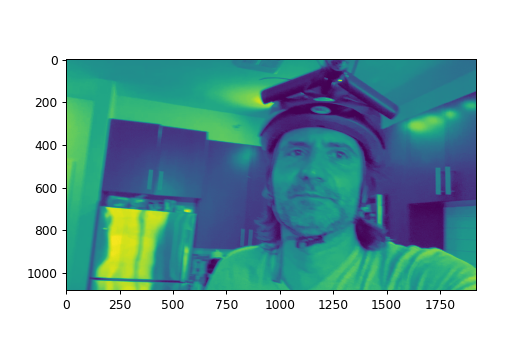

<IPython.core.display.Javascript object>


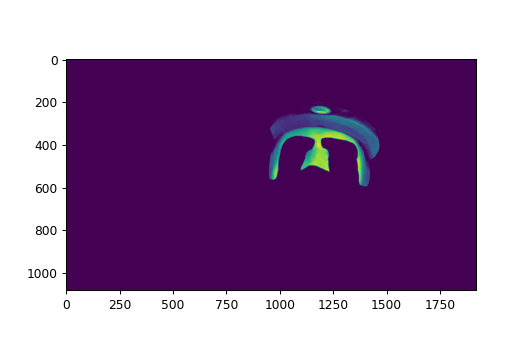

<IPython.core.display.Javascript object>


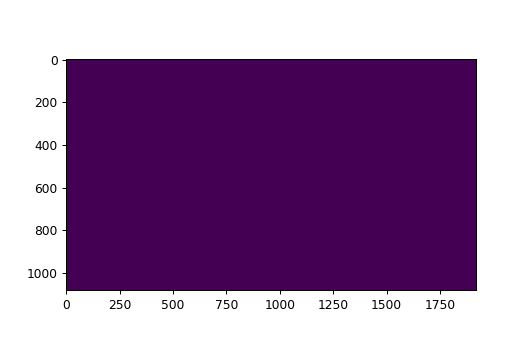

<IPython.core.display.Javascript object>


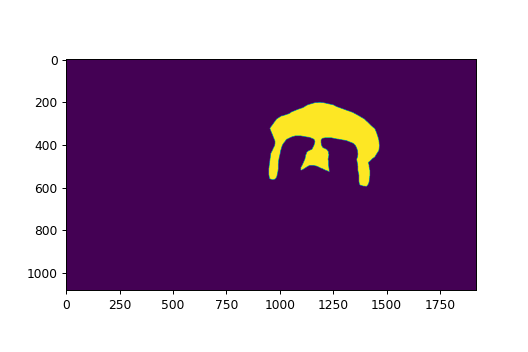

In [372]:
# dir_vid = Path(r'/home/rich/Downloads').resolve()
# fileName_vid = r'Video2_raw.mov'
# path_vid = dir_vid / fileName_vid

path_vid = config['General']['sessions'][0]['videos'][0]

vid = imageio.get_reader(path_vid, 'ffmpeg')

vid_tmp = cv2.VideoCapture(str(path_vid))  # open the video object with openCV
numFrames_rough = int(vid_tmp.get(
    cv2.CAP_PROP_FRAME_COUNT))  # get frame count of this vid GENERALLY INACCURATE by around 0.1-10%.
numFrames_rough

frameToSet = 0
frame_ref = vid.get_data(frameToSet)  # Get a single frame to use as the first 'previous frame' in calculating optic flow
frame_ref = cv2.cvtColor(frame_ref,cv2.COLOR_BGR2GRAY)
frame_ref_crop = crop_frame(frame_ref , pts_y , pts_x , plot_pref=1)
frame_mask = crop_frame(np.ones_like(frame_ref) , pts_y , pts_x , plot_pref=1)

In [373]:

# Define the motion model
warp_mode = cv2.MOTION_EUCLIDEAN

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 10;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-2;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)


showVideo_pref = True
ind_concat = 0
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    
    # look through the NWB outputs (see above example) to see available arrays to plot and how to access them
    positions_moCorr = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_absolute'].data[:]
    pointInds_ref = nwbfile.processing['Face Rhythm']['Optic Flow']['pts_spaced_convDR'].data[:]
    
#     print(positions_moCorr.shape)
    
    n_frames = positions_moCorr.shape[2]
    euclidean_coeffs = np.zeros((n_frames , 2,3))
    
    for iter_frame, frame in enumerate(tqdm(vid, total=numFrames_rough)):
        euclidean_coeffs[iter_frame] = cv2.estimateAffinePartial2D( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.9999999 , method=cv2.RANSAC , ransacReprojThreshold=5)[0]
#         euclidean_coeffs[iter_frame] = cv2.findHomography( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.99 , method=cv2.RANSAC)[0]
#         euclidean_coeffs[iter_frame] = cv2.estimateAffine2D( pointInds_ref[:,0,:], positions_moCorr[:,:,iter_frame] , confidence=.99 , method=cv2.RANSAC)[0]
        
        frame_moving = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
#         frame_moving_crop = crop_frame(frame , pts_y , pts_x , plot_pref=0)
        

        # Run the ECC algorithm. The results are stored in warp_matrix.
#         (cc, warp_matrix) = cv2.findTransformECC (frame_ref_crop, frame_moving, warp_matrix, warp_mode, criteria , inputMask=frame_mask , gaussFiltSize=1)
        (cc, warp_matrix) = cv2.findTransformECC (frame_ref, frame_moving, warp_matrix, warp_mode, criteria , inputMask=frame_mask , gaussFiltSize=1)


    #     new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
#         frame_MC = cv2.warpAffine(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) , flags=cv2.WARP_INVERSE_MAP )
        frame_MC = cv2.warpAffine(src=frame , M=warp_matrix , dsize=(frame.shape[1] , frame.shape[0]) , flags=cv2.WARP_INVERSE_MAP )
#         frame_MC = cv2.warpPerspective(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) , flags=cv2.WARP_INVERSE_MAP )
    #     frame_MC = cv2.warpAffine(src=frame , M=euclidean_coeffs[iter_frame] , dsize=(frame.shape[1] , frame.shape[0]) )

        if showVideo_pref:
            dot_size=2
            for ii in range(pointInds_ref.shape[0]):
#                 point_inds_tracked_tuple = tuple(np.int64(np.squeeze(pointInds_ref[ii, 0, :])))
                point_inds_tracked_tuple = tuple(np.int64(np.squeeze(positions_moCorr[ii, :, iter_frame])))
#                 cv2.circle(frame, point_inds_tracked_tuple, dot_size, color_tuples[ii], -1)
#                 cv2.circle(frame, point_inds_tracked_tuple, dot_size, (255,255,255), -1)

            cv2.imshow('Display Factors', frame_MC)
#             cv2.imshow('Display Factors', frame)

            k = cv2.waitKey(1) & 0xff
            if k == 27: break

        ind_concat = ind_concat + 1

    # for ii in trange(n_frames):
    #     frame_MC = cv2.warpAffine()

 13%|█▎        | 1317/10245 [03:19<22:31,  6.61it/s]


KeyboardInterrupt: 

simple kalman filter demo

In [401]:
import cv2, numpy as np

meas=[]
pred=[]
frame = np.zeros((400,400,3), np.uint8) # drawing canvas
mp = np.array((2,1), np.float32) # measurement
tp = np.zeros((2,1), np.float32) # tracked / prediction

def onmouse(k,x,y,s,p):
    global mp,meas
    mp = np.array([[np.float32(x)],[np.float32(y)]])
    meas.append((x,y))

def paint():
    global frame,meas,pred
    for i in range(len(meas)-1): cv2.line(frame,meas[i],meas[i+1],(0,100,0))
    for i in range(len(pred)-1): cv2.line(frame,pred[i],pred[i+1],(0,0,200))

def reset():
    global meas,pred,frame
    meas=[]
    pred=[]
    frame = np.zeros((400,400,3), np.uint8)

cv2.namedWindow("kalman")
cv2.setMouseCallback("kalman",onmouse);
kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.0003
#kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * 0.00003
while True:
    kalman.correct(mp)
    tp = kalman.predict()
    pred.append((int(tp[0]),int(tp[1])))
    paint()
    cv2.imshow("kalman",frame)
    k = cv2.waitKey(30) &0xFF
    if k == 27: break
    if k == 32: reset()

KeyboardInterrupt: 